# OCBC AI Lab Text clustering 

# Methodology 
1. Text preprocessing
2. Create count vectorizer to convert text into vectors
3. Create a baseline model using Gensim’s LDA to cluster each document
- set seed in LDA model to ensure reproduciblity
4. Visualize the cluster using word cloud (to display the top 200 words)
5. Evaluate the model using Coherence score
6. Perform hyperparameter tuning to get optimize hyperparameters (alpha, beta, number of topics)

In [1]:
## imports
import pandas as pd
import numpy as np
import tqdm
from collections import Counter
import nltk
import re
import joblib
from tqdm import trange

# check language of text
import langid

# gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel # to evaluate lda model
from pprint import pprint

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer

# set seed to ensure reproduciblity
SEED = 100

## set wider column to display text
pd.set_option('display.max_colwidth', 500) 

import warnings
warnings.filterwarnings('ignore')

# helper fns
from utils import *

In [1]:
# helper fns
from utils import *

C:\Users\valerie_l\Miniconda3\envs\sandbox_conda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valerie_l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valerie_l\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def partial_utils_preprocess_text(text, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().replace("/", " ").strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    return lst_text
c = 'I told you that she was not happy'
partial_utils_preprocess_text(c, lst_stopwords=stopwords)

['told', 'happy']

## Expt 1: Remove english stopwords and words that appear >60% in document and build baseline model
#### 1. Text preprocessing  
i. Joined title and content to get a fuller representation of each document

ii. Remove stopwords

iii. Perform lemmatization

In [2]:
df = pd.read_csv('./data/raw/news_data.csv')

In [3]:
df.isnull().sum()

altid      0
title      0
content    0
dtype: int64

In [4]:
assert df['altid'].nunique() == len(df)
# no duplicated id

In [5]:
df.head()

,altid,title,content
0,sa1a70ab8ef5,Davenport hits out at Wimbledon,"World number one Lindsay Davenport has criticised Wimbledon over the issue of equal prize money for women. Reacting to a disputed comment by All England Club chairman Tim Phillips, the American said: ""I think it is highly insulting if prize money is taken away. ""Somebody, I think it was Mr Phillips, said they won't have money for flowers at Wimbledon. That's insulting."" An All England club spokesperson denied Phillips made the remark, insisting: ""He definitely didn't say it."" The statement..."
1,ta497aea0e36,Camera phones are 'must-haves',"Four times more mobiles with cameras in them will be sold in Europe by the end of 2004 than last year, says a report from analysts Gartner. Globally, the number sold will reach 159 million, an increase of 104%. The report predicts that nearly 70% of all mobile phones sold will have a built-in camera by 2008. Improving imaging technology in mobiles is making them an increasingly ""must-have"" buy. In Europe, cameras on mobiles can take 1.3 megapixel images. But in Japan and Asia Pacific, wher..."
2,ta0f0fa26a93,US top of supercomputing charts,"The US has pushed Japan off the top of the supercomputing chart with IBM's prototype Blue Gene/L machine. It is being assembled for the Lawrence Livermore National Laboratory, under the US Department of Energy. IBM test results show that Blue Gene/L has managed speeds of 70.72 teraflops. The previous top machine, Japan's NEC Earth Simulator, clocked up 35.86. The Top 500 list was announced on Monday and officially charts the fastest computers in the world. It is announced every six months..."
3,ba23aaa4f4bb,Trial begins of Spain's top banker,"The trial of Emilio Botin, the chairman of Spain's most powerful bank, Santander Central Hispano, has started in Madrid. Mr Botin is accused of misusing the bank's funds after he approved the payment of 160m euros ($208m; £111m) in bonus and pension payouts to two former executives. However, the trial was suspended when Mr Botin's lawyer introduced a new set of documents on the day testimony was set to begin. A three-judge panel gave prosecution lawyers until Monday to study the documents,..."
4,baa126aeb946,Safety alert as GM recalls cars,"The world's biggest carmaker General Motors (GM) is recalling nearly 200,000 vehicles in the US on safety grounds, according to federal regulators. The National Highway Traffic Safety Administration (NHTSA) said the largest recall involves 155,465 pickups, vans and sports utility vehicles (SUVs). This is because of possible malfunctions with the braking systems. The affected vehicles in the product recall are from the 2004 and 2005 model years, GM said. Those vehicles with potential faults..."


In [6]:
# concatenate title and content as 1 attribute title_and_content
df['title_and_content'] = df['title'] + df['content']
df['lang'] = df['title_and_content'].apply(lambda x: langid.classify(x)[0]) 
df['lang'].unique()
## all content in english. no translation needed

array(['en'], dtype=object)

In [7]:
# since all content in english, let's download english stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words("english")
nltk_stopwords_len = len(stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valerie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/valerie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/valerie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
# process texts
df['title_and_content_lemm'] = df['title_and_content'].apply(lambda c: utils_preprocess_text(c, lst_stopwords=stopwords))

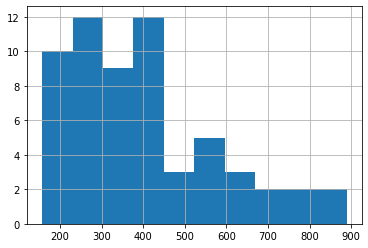

In [10]:
df['title_and_content_len'] = df['title_and_content'].apply(lambda x: len(str(x).split(' ')))
df['title_and_content_len'].hist();
# the distribution plot below is right skewed, 
# which shows there are some very long articles (600-800 words long)

In [11]:
df['title_and_content_len'].describe()
## average number of words per article ~400. there are some longer articles

count     60.000000
mean     400.100000
std      183.196634
min      157.000000
25%      250.000000
50%      371.500000
75%      504.250000
max      889.000000
Name: title_and_content_len, dtype: float64

In [12]:
df.head(2)

,altid,title,content,title_and_content,lang,title_and_content_lemm,title_and_content_len
0,sa1a70ab8ef5,Davenport hits out at Wimbledon,"World number one Lindsay Davenport has criticised Wimbledon over the issue of equal prize money for women. Reacting to a disputed comment by All England Club chairman Tim Phillips, the American said: ""I think it is highly insulting if prize money is taken away. ""Somebody, I think it was Mr Phillips, said they won't have money for flowers at Wimbledon. That's insulting."" An All England club spokesperson denied Phillips made the remark, insisting: ""He definitely didn't say it."" The statement...","Davenport hits out at Wimbledon World number one Lindsay Davenport has criticised Wimbledon over the issue of equal prize money for women. Reacting to a disputed comment by All England Club chairman Tim Phillips, the American said: ""I think it is highly insulting if prize money is taken away. ""Somebody, I think it was Mr Phillips, said they won't have money for flowers at Wimbledon. That's insulting."" An All England club spokesperson denied Phillips made the remark, insisting: ""He definitel...",en,"[davenport, hit, wimbledon, world, number, one, lindsay, davenport, criticised, wimbledon, issue, equal, prize, money, woman, , reacting, disputed, comment, england, club, chairman, tim, phillips, american, said, think, highly, insulting, prize, money, taken, away, somebody, think, mr, phillips, said, wont, money, flower, wimbledon, thats, insulting, england, club, spokesperson, denied, phillips, made, remark, insisting, definitely, didnt, say, statement, added, said, someone, else, humorous...",250
1,ta497aea0e36,Camera phones are 'must-haves',"Four times more mobiles with cameras in them will be sold in Europe by the end of 2004 than last year, says a report from analysts Gartner. Globally, the number sold will reach 159 million, an increase of 104%. The report predicts that nearly 70% of all mobile phones sold will have a built-in camera by 2008. Improving imaging technology in mobiles is making them an increasingly ""must-have"" buy. In Europe, cameras on mobiles can take 1.3 megapixel images. But in Japan and Asia Pacific, wher...","Camera phones are 'must-haves' Four times more mobiles with cameras in them will be sold in Europe by the end of 2004 than last year, says a report from analysts Gartner. Globally, the number sold will reach 159 million, an increase of 104%. The report predicts that nearly 70% of all mobile phones sold will have a built-in camera by 2008. Improving imaging technology in mobiles is making them an increasingly ""must-have"" buy. In Europe, cameras on mobiles can take 1.3 megapixel images. But i...",en,"[camera, phone, musthaves, four, time, mobile, camera, sold, europe, end, 2004, last, year, say, report, analyst, gartner, , globally, number, sold, reach, 159, million, increase, 104, report, predicts, nearly, 70, mobile, phone, sold, builtin, camera, 2008, improving, imaging, technology, mobile, making, increasingly, musthave, buy, europe, camera, mobile, take, 13, megapixel, image, japan, asia, pacific, camera, phone, technology, much, advanced, mobile, already, released, take, 32, megapi...",574


In [13]:
TOP_N = 50
df['joined_tokens'] = df['title_and_content_lemm'].apply(lambda x: " ".join(x))

n_freq_words = Counter(" ".join(df['joined_tokens']).split()).most_common(TOP_N)
n_freq_words[:5]

[('said', 206), ('mr', 128), ('year', 85), ('would', 76), ('people', 73)]

In [14]:
# find % that each word in freq words appear in data

for word in n_freq_words:
    print(word, len(df[df['joined_tokens'].str.contains(word[0])])/len(df) * 100)

('said', 206) 90.0
('mr', 128) 41.66666666666667
('year', 85) 61.66666666666667
('would', 76) 51.66666666666667
('people', 73) 45.0
('also', 68) 65.0
('world', 50) 35.0
('new', 48) 60.0
('u', 44) 100.0
('one', 43) 73.33333333333333
('first', 41) 43.333333333333336
('blair', 41) 10.0
('could', 40) 36.666666666666664
('last', 39) 50.0
('say', 37) 40.0
('game', 37) 21.666666666666668
('labour', 37) 16.666666666666664
('radio', 35) 13.333333333333334
('two', 35) 46.666666666666664
('tax', 32) 11.666666666666666
('number', 31) 26.666666666666668
('made', 31) 36.666666666666664
('well', 31) 40.0
('time', 31) 40.0
('show', 31) 30.0
('service', 30) 26.666666666666668
('bank', 30) 13.333333333333334
('sale', 30) 13.333333333333334
('government', 30) 20.0
('minister', 30) 18.333333333333332
('told', 30) 31.666666666666664
('make', 29) 40.0
('way', 29) 46.666666666666664
('many', 29) 30.0
('end', 28) 78.33333333333333
('music', 28) 16.666666666666664
('get', 28) 48.333333333333336
('rate', 28) 38

Frequent words (e.g. 'said', 'u', 'new', 'year' appear more than 60% across the documents). Treat words that appear > 60% of the time as additional stopwords

In [15]:
COMMON_WORDS_THRESHOLD = 60
custom_stopwords_list = create_custom_stopwords_list(COMMON_WORDS_THRESHOLD, n_freq_words, df, 'joined_tokens')
custom_stopwords_list

['said', 'year', 'also', 'u', 'one', 'end']

In [16]:
stopwords.extend(custom_stopwords_list)
# check if number of stopwords after adding custom stopwords is correct
assert len(stopwords) == nltk_stopwords_len + len(custom_stopwords_list)

In [17]:
# remove new list of stopwords from `title and content` then lemmatize it
df['title_and_content_lemm_rm_freq_words'] = df['title_and_content'].apply(lambda x:utils_preprocess_text(x, lst_stopwords=stopwords, flg_lemm=False))
df.head(1)
                                                                                     

,altid,title,content,title_and_content,lang,title_and_content_lemm,title_and_content_len,joined_tokens,title_and_content_lemm_rm_freq_words
0,sa1a70ab8ef5,Davenport hits out at Wimbledon,"World number one Lindsay Davenport has criticised Wimbledon over the issue of equal prize money for women. Reacting to a disputed comment by All England Club chairman Tim Phillips, the American said: ""I think it is highly insulting if prize money is taken away. ""Somebody, I think it was Mr Phillips, said they won't have money for flowers at Wimbledon. That's insulting."" An All England club spokesperson denied Phillips made the remark, insisting: ""He definitely didn't say it."" The statement...","Davenport hits out at Wimbledon World number one Lindsay Davenport has criticised Wimbledon over the issue of equal prize money for women. Reacting to a disputed comment by All England Club chairman Tim Phillips, the American said: ""I think it is highly insulting if prize money is taken away. ""Somebody, I think it was Mr Phillips, said they won't have money for flowers at Wimbledon. That's insulting."" An All England club spokesperson denied Phillips made the remark, insisting: ""He definitel...",en,"[davenport, hit, wimbledon, world, number, one, lindsay, davenport, criticised, wimbledon, issue, equal, prize, money, woman, , reacting, disputed, comment, england, club, chairman, tim, phillips, american, said, think, highly, insulting, prize, money, taken, away, somebody, think, mr, phillips, said, wont, money, flower, wimbledon, thats, insulting, england, club, spokesperson, denied, phillips, made, remark, insisting, definitely, didnt, say, statement, added, said, someone, else, humorous...",250,davenport hit wimbledon world number one lindsay davenport criticised wimbledon issue equal prize money woman reacting disputed comment england club chairman tim phillips american said think highly insulting prize money taken away somebody think mr phillips said wont money flower wimbledon thats insulting england club spokesperson denied phillips made remark insisting definitely didnt say statement added said someone else humorous aside end radio interview conversation moved talking wimbled...,"[davenport, hits, wimbledon, world, number, lindsay, davenport, criticised, wimbledon, issue, equal, prize, money, women, , reacting, disputed, comment, england, club, chairman, tim, phillips, american, think, highly, insulting, prize, money, taken, away, somebody, think, mr, phillips, wont, money, flowers, wimbledon, thats, insulting, england, club, spokesperson, denied, phillips, made, remark, insisting, definitely, didnt, say, statement, added, someone, else, humorous, aside, radio, inter..."


#### 2. Create count vectorizer to convert text into vectors and generate T-D matrix

In [18]:
# Create Dictionary
DOCUMENT = df['title_and_content_lemm_rm_freq_words'].values.tolist()
id2word = corpora.Dictionary(DOCUMENT)
# Create Corpus (count vectorizer)
# Create Term Document Frequency cuz gensim likes T-D matrix
# so the terms (unigrams) are the rows. columns are the documents
corpus = [id2word.doc2bow(text) for text in DOCUMENT]
# View
print(corpus[:1])
# The produced corpus shown above is a mapping of (word_id, word_frequency). 
# E.g. (0, 1) below in the output implies, word id 0 occurs once in the 3rd document.

[[(0, 3), (1, 3), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 2), (29, 2), (30, 3), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 5), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 3), (69, 1), (70, 1), (71, 4), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 4), (99, 6), (100, 1), (101, 1), (102, 1), (103, 1)]]


#### 3. Create a baseline model using Gensim’s LDA to cluster each document 
- Set number of topics to be discovered as 5 
- I used gensim over sklearn's LDA library because there are more relevant functions available in gensim, e.g. coherence score to evaluate model. 

In [19]:
# Build LDA model (baseline)
NUM_TOPICS=5
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=NUM_TOPICS, 
                                       random_state=SEED, #set seed to ensure reproducibility
                                       chunksize=100, #Number of documents to be used in each training chunk
                                       passes=10, # number of epochs
                                       per_word_topics=True)

In [20]:
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
# Assigns the topics to the documents in corpus
doc_lda = lda_model[corpus]

[(0,
  '0.012*"" + 0.008*"radio" + 0.005*"visual" + 0.004*"life" + 0.004*"market" + '
  '0.004*"could" + 0.003*"banks" + 0.003*"last" + 0.003*"euniversity" + '
  '0.003*"years"'),
 (1,
  '0.016*"" + 0.012*"mr" + 0.006*"would" + 0.005*"blair" + 0.005*"labour" + '
  '0.004*"election" + 0.004*"brown" + 0.004*"players" + 0.004*"prime" + '
  '0.004*"music"'),
 (2,
  '0.024*"" + 0.006*"people" + 0.004*"mr" + 0.004*"broadband" + 0.004*"net" + '
  '0.003*"world" + 0.003*"new" + 0.003*"many" + 0.003*"programs" + '
  '0.003*"first"'),
 (3,
  '0.016*"" + 0.007*"would" + 0.005*"sales" + 0.005*"people" + 0.004*"mr" + '
  '0.004*"bank" + 0.003*"cards" + 0.003*"id" + 0.003*"50" + 0.003*"economy"'),
 (4,
  '0.014*"" + 0.011*"mr" + 0.004*"top" + 0.003*"cable" + 0.003*"us" + '
  '0.003*"new" + 0.003*"tv" + 0.003*"show" + 0.003*"viacom" + '
  '0.003*"telewest"')]


#### 4. Evaluate the model using Coherence score
- Coherence score measures how well the topics are extracted by measuring relative distance between words within a topic
- There are different types of coherence score metrics. I used `c_v` which is based on a sliding window, a one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity.
- `c_v` measure retrieves cooccurrence counts for the given words using a sliding window  and the window size 110. The counts are used to calculated the NPMI of every top word to every other top word, thus, resulting in a set of vectors—one for every top word. The one-set segmentation of the top words leads to the calculation of the similarity between every top word vector and the sum of all top word vectors. 
- The coherence is the arithmetic mean of these similarities.

In [21]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=DOCUMENT, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.33141683759794444


#### 5. Visualize the cluster using word cloud

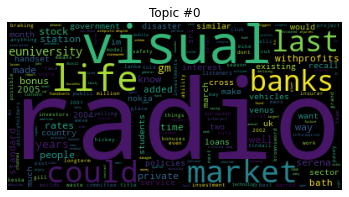

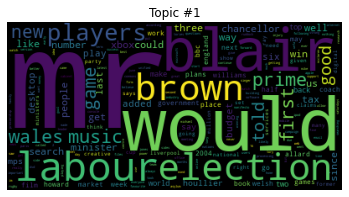

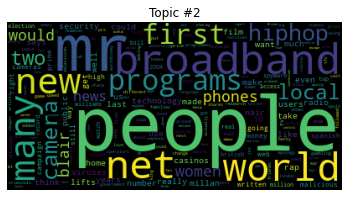

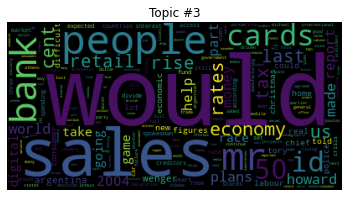

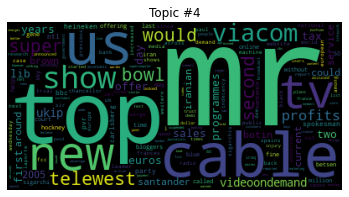

In [22]:
num_words_in_wc = 200
visualize_cluster_word_cloud(lda_model, num_words_in_wc)

## Expt 2: Remove english stopwords and words that appear >30% in document and build 2nd model
- Common words like "mr" that appears 41% of the time are prominently found in topic 1, 2 and 4, as seen in the size of the word
- Hence, in expt2, I lowered COMMON_WORD_THRESHOLD to 30% to remove more frequent words

#### 1. Text preprocessing

In [23]:
COMMON_WORDS_THRESHOLD_2 = 30
custom_stopwords_list_2 = create_custom_stopwords_list(COMMON_WORDS_THRESHOLD_2, n_freq_words, df, 'joined_tokens')
stopwords_len_expt1 = len(stopwords)
stopwords.extend(custom_stopwords_list_2)
stopwords = list(set(stopwords))
# check if number of stopwords after adding custom stopwords is correct
assert len(stopwords) == nltk_stopwords_len + len(custom_stopwords_list_2)

In [24]:
# remove new list of stopwords from `title and content` then lemmatize it
df['title_and_content_lemm_rm_freq_words_2'] = df['title_and_content'].apply(lambda x:utils_preprocess_text(x, lst_stopwords=stopwords, flg_lemm=False))
df.head(1)
                                                                                     

,altid,title,content,title_and_content,lang,title_and_content_lemm,title_and_content_len,joined_tokens,title_and_content_lemm_rm_freq_words,title_and_content_lemm_rm_freq_words_2
0,sa1a70ab8ef5,Davenport hits out at Wimbledon,"World number one Lindsay Davenport has criticised Wimbledon over the issue of equal prize money for women. Reacting to a disputed comment by All England Club chairman Tim Phillips, the American said: ""I think it is highly insulting if prize money is taken away. ""Somebody, I think it was Mr Phillips, said they won't have money for flowers at Wimbledon. That's insulting."" An All England club spokesperson denied Phillips made the remark, insisting: ""He definitely didn't say it."" The statement...","Davenport hits out at Wimbledon World number one Lindsay Davenport has criticised Wimbledon over the issue of equal prize money for women. Reacting to a disputed comment by All England Club chairman Tim Phillips, the American said: ""I think it is highly insulting if prize money is taken away. ""Somebody, I think it was Mr Phillips, said they won't have money for flowers at Wimbledon. That's insulting."" An All England club spokesperson denied Phillips made the remark, insisting: ""He definitel...",en,"[davenport, hit, wimbledon, world, number, one, lindsay, davenport, criticised, wimbledon, issue, equal, prize, money, woman, , reacting, disputed, comment, england, club, chairman, tim, phillips, american, said, think, highly, insulting, prize, money, taken, away, somebody, think, mr, phillips, said, wont, money, flower, wimbledon, thats, insulting, england, club, spokesperson, denied, phillips, made, remark, insisting, definitely, didnt, say, statement, added, said, someone, else, humorous...",250,davenport hit wimbledon world number one lindsay davenport criticised wimbledon issue equal prize money woman reacting disputed comment england club chairman tim phillips american said think highly insulting prize money taken away somebody think mr phillips said wont money flower wimbledon thats insulting england club spokesperson denied phillips made remark insisting definitely didnt say statement added said someone else humorous aside end radio interview conversation moved talking wimbled...,"[davenport, hits, wimbledon, world, number, lindsay, davenport, criticised, wimbledon, issue, equal, prize, money, women, , reacting, disputed, comment, england, club, chairman, tim, phillips, american, think, highly, insulting, prize, money, taken, away, somebody, think, mr, phillips, wont, money, flowers, wimbledon, thats, insulting, england, club, spokesperson, denied, phillips, made, remark, insisting, definitely, didnt, say, statement, added, someone, else, humorous, aside, radio, inter...","[davenport, hits, wimbledon, number, lindsay, davenport, criticised, wimbledon, issue, equal, prize, money, women, , reacting, disputed, comment, england, club, chairman, tim, phillips, american, think, highly, insulting, prize, money, taken, away, somebody, think, phillips, wont, money, flowers, wimbledon, thats, insulting, england, club, spokesperson, denied, phillips, remark, insisting, definitely, didnt, statement, someone, else, humorous, aside, radio, interview, conversation, moved, ta..."


#### 2. Create count vectorizer to convert text into vectors and generate T-D matrix

In [25]:
DOCUMENT_2 = df['title_and_content_lemm_rm_freq_words_2'].values.tolist()
id2word_2, corpus_2 = create_dict_and_corpus(DOCUMENT_2)

#### 3. Create LDA model

In [26]:
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus_2,
                                       id2word=id2word_2,
                                       num_topics=NUM_TOPICS, 
                                       random_state=SEED,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
pprint(lda_model_2.print_topics())

[(0,
  '0.011*"" + 0.010*"sales" + 0.005*"us" + 0.005*"number" + 0.005*"casinos" + '
  '0.004*"life" + 0.004*"profits" + 0.003*"market" + 0.003*"rates" + '
  '0.003*"stock"'),
 (1,
  '0.016*"" + 0.003*"us" + 0.003*"hiphop" + 0.003*"phones" + 0.003*"game" + '
  '0.003*"show" + 0.003*"camera" + 0.003*"says" + 0.003*"women" + 0.003*"50"'),
 (2,
  '0.012*"" + 0.004*"telewest" + 0.004*"ukip" + 0.004*"videoondemand" + '
  '0.004*"houllier" + 0.003*"programmes" + 0.003*"offer" + 0.003*"bbc" + '
  '0.003*"party" + 0.003*"members"'),
 (3,
  '0.020*"" + 0.008*"blair" + 0.007*"labour" + 0.006*"election" + '
  '0.006*"brown" + 0.005*"tax" + 0.005*"prime" + 0.004*"chancellor" + '
  '0.004*"minister" + 0.004*"broadband"'),
 (4,
  '0.024*"" + 0.005*"radio" + 0.003*"music" + 0.003*"us" + 0.003*"many" + '
  '0.003*"players" + 0.003*"years" + 0.003*"visual" + 0.002*"williams" + '
  '0.002*"search"')]


#### 4. Evaluate and compare expt1 and 2 coherence score 

In [27]:
# Compute Coherence Score
coherence_model_lda_2 = CoherenceModel(model=lda_model_2, texts=DOCUMENT_2, dictionary=id2word_2, coherence='c_v')
coherence_lda_2 = coherence_model_lda_2.get_coherence()
print('\nCoherence Score: ', coherence_lda_2)
print('\n % improvement: ', (coherence_lda_2-(coherence_lda))/coherence_lda_2*100)
# around 24% improvement in Coherence Score


Coherence Score:  0.43482692240195603

 % improvement:  23.78189561786582


#### 5. Visualize the cluster using word cloud

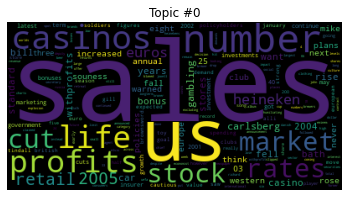

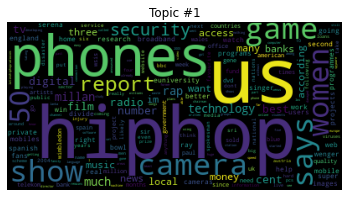

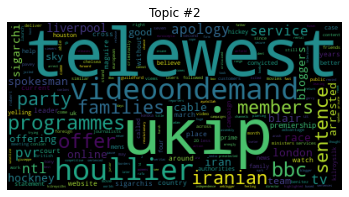

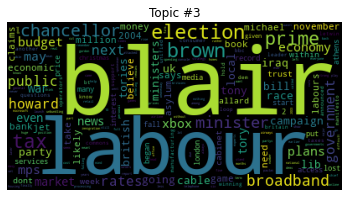

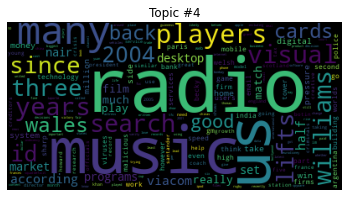

In [28]:
visualize_cluster_word_cloud(lda_model_2, num_words_in_wc)

## Expt 3: Hyperparameter tuning
- Let's try improving the baseline models. Instead of trying random number of topics, let's define the hyperparameter search space by setting a range of number of topics, alpha and beta values
- alpha: A-priori belief on document-topic distribution
    - Higher the value of alpha, documents are composed of more topics
- beta: A-priori belief on topic-word distribution
    - higher the beta, topics are composed of a large number of words in the corpus, 

#### 1. Define the hyperparameter search space and run a LDA model for each combination of hyperparameter

In [32]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus_2)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus_2, int(num_of_docs*0.75)), 
               corpus_2]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
# iterate through validation corpuses
for i in trange(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus_sets[i], 
                                              document=DOCUMENT_2,
                                              dictionary=id2word_2, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)


model_results_df = pd.DataFrame(model_results)
model_results_df.to_csv('data/processed/lda_hp_tuning_results.csv', index=False)

100%|█████████████████████████████████████████████████████| 2/2 [20:11<00:00, 605.65s/it]


In [33]:
model_results_df

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.349729
1,75% Corpus,2,0.01,0.31,0.337517
2,75% Corpus,2,0.01,0.61,0.439248
3,75% Corpus,2,0.01,0.91,0.439248
4,75% Corpus,2,0.01,symmetric,0.395571
...,...,...,...,...,...
475,100% Corpus,9,asymmetric,0.01,0.403982
476,100% Corpus,9,asymmetric,0.31,0.400011
477,100% Corpus,9,asymmetric,0.61,0.405626
478,100% Corpus,9,asymmetric,0.91,0.419759


In [34]:
# filter for the model result with the highest coherence score
model_results_df.iloc[model_results_df['Coherence'].idxmax()]

Validation_Set    100% Corpus
Topics                      7
Alpha                    0.01
Beta                     0.91
Coherence            0.480325
Name: 393, dtype: object

#### 2. Evaluate and compare expt2 and 3 coherence score 

In [35]:
print('\n % improvement: ', (model_results_df['Coherence'].max()-coherence_lda_2)/coherence_lda_2*100)
## hyperparameter tuning improved expt2's result by 10%


 % improvement:  10.46357120676682


In [36]:
num_topics_optimum = model_results_df.iloc[model_results_df['Coherence'].idxmax(), 1]
alpha_optimum = model_results_df.iloc[model_results_df['Coherence'].idxmax(), 2]
beta_optimum = model_results_df.iloc[model_results_df['Coherence'].idxmax(), 3]
print(f'num_topics_optimum: {num_topics_optimum} \n alpha_optimum: {alpha_optimum} \n beta_optimum: {beta_optimum}')

num_topics_optimum: 7 
 alpha_optimum: 0.01 
 beta_optimum: 0.9099999999999999


#### 3. Apply the best combination of hyperparameters to create the optimum LDA model

In [37]:
lda_model_optimium = gensim.models.LdaMulticore(corpus=corpus_2,
                                           id2word=id2word_2,
                                           num_topics=num_topics_optimum, 
                                           random_state=SEED,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha_optimum,
                                           eta=beta_optimum)

#### 4. Visualize the cluster using word cloud

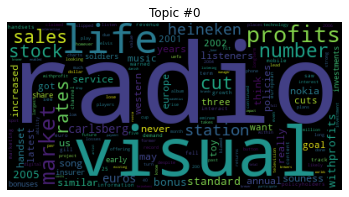

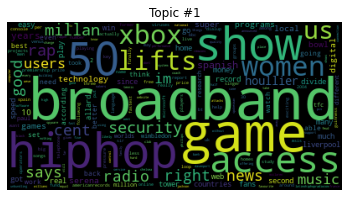

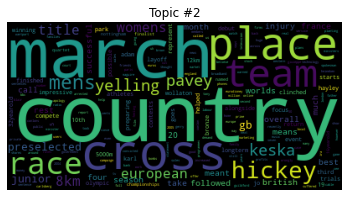

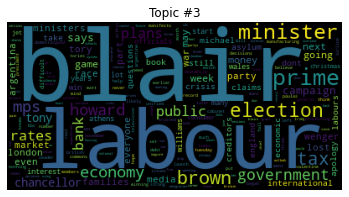

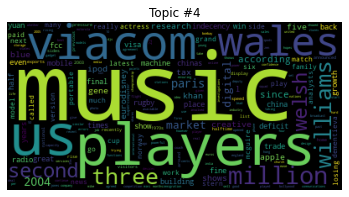

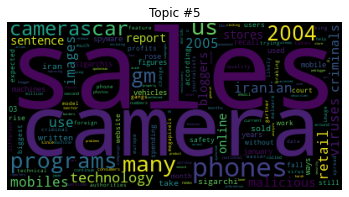

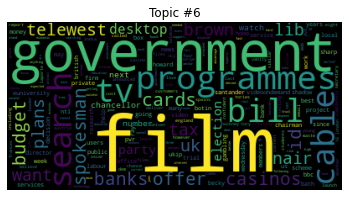

In [38]:
visualize_cluster_word_cloud(lda_model_optimium, num_words_in_wc)

Topics: 
- Topic 0: stock market
- Topic 1: music, gaming
- Topic 2: sports
- Topic 3: politics
- Topic 4: sports
- Topic 5: gadgets
- Topic 6: government

In [39]:
# Assigns the topics to the documents in corpus
doc_lda_optimium = lda_model_optimium[corpus_2]
doc_lda_optimium

In [40]:
## pickle model objects
joblib.dump(lda_model_optimium, './models/trained_lda.pkl')
joblib.dump(doc_lda_optimium, './data/processed/doc_lda_optimium.pkl')

['./data/processed/doc_lda_optimium.pkl']

In [41]:
## find out how many articles per topic
topic_num = []
for topic in doc_lda_optimium:
    topic_num.append(topic[0][0])
df['topic_num'] = topic_num
df.groupby('topic_num')['altid'].count().reset_index(name='num_articles')


,topic_num,num_articles
0,0,5
1,1,13
2,2,1
3,3,13
4,4,8
5,5,5
6,6,15


In [42]:
## sample title/content for each proposed topic
for t in range(lda_model_optimium.num_topics):
    print(f'topic {t}')
    try: 
        display(df[['title_and_content']].loc[df['topic_num']==t].sample(3, random_state=SEED))
    except ValueError:
        display(df[['title_and_content']].loc[df['topic_num']==t].head(3))

topic 0


,title_and_content
28,"Souness delight at Euro progress Boss Graeme Souness felt Newcastle were never really in danger of going out of the Uefa Cup against Heerenveen. An early own goal followed by an Alan Shearer strike earned them a 2-1 win and a place in the Uefa Cup last 16. ""Obviously with winning in the first leg it gave us a great advantage,"" he said after the 4-2 aggregate victory. ""We got our goals early and in the minds of some players the job was done but then they got a goal and perhaps made us a bit ..."
41,"Standard Life cuts policy bonuses Standard Life, Europe's largest mutual life insurer, has cut bonuses for with-profit policyholders. Annual bonus rates on its with-profits life policies were cut from 2.5% to 2%, while bonuses on pension policies were reduced from 3.25% to 2.5%. It is the sixth time in three years Standard Life has made cuts to bonus rates, despite an 8.7% rise in the value of the with-profits fund in 2004. The insurer blamed the cuts on poor share returns and low interest ..."
44,"Brewers' profits lose their fizz Heineken and Carlsberg, two of the world's largest brewers, have reported falling profits after beer sales in western Europe fell flat. Dutch firm Heineken saw its annual profits drop 33% and warned that earnings in 2005 may also slide. Danish brewer Carlsberg suffered a 3% fall in profits due to waning demand and increased marketing costs. Both are looking to Russia and China to provide future growth as western European markets are largely mature. Heineken..."


topic 1


,title_and_content
55,"More women turn to net security Older people and women are increasingly taking charge of protecting home computers against malicious net attacks, according to a two-year study. The number of women buying programs to protect PCs from virus, spam and spyware attacks rose by 11.2% each year between 2002 and 2004. The study, for net security firm Preventon, shows that security messages are reaching a diversity of surfers. It is thought that 40% of those buying home net security programs are ret..."
17,"Sir Paul rocks Super Bowl crowds Sir Paul McCartney wowed fans with a live mini-concert at American football's Super Bowl - and avoided any Janet Jackson-style controversies. The 62-year-old sang Hey Jude and other Beatles songs in a 12-minute set at half-time during the game in Florida. Last year, Jackson exposed a breast during a dance routine, causing outrage among millions of TV viewers and landing the CBS TV network a fine. Sir Paul, however, did nothing more racy than remove his jacke..."
5,"Angry Williams rejects criticism Serena Williams has angrily rejected claims that she and sister Venus are a declining force in tennis. The sisters ended last year without a Grand Slam title for the first time since 1998. But Serena denied their challenge was fading, saying: ""That's not fair - I'm tired of not saying anything. ""We've been practising hard. We've had serious injuries. I've had surgery and after, I got to the Wimbledon final. I don't know many who have done that."" While Serena..."


topic 2


,title_and_content
14,"GB quartet get cross country call Four British athletes have been pre-selected to compete at the World Cross Country Championships in March after impressive starts to the season. Hayley Yelling, Jo Pavey, Karl Keska and Adam Hickey will represent Team GB at the event in France. Yelling clinched the women's European cross country title last month and Pavey followed up with bronze. Keska helped the men's team to overall third place while Hickey finished in 10th place on his junior debut. ""Win..."


topic 3


,title_and_content
46,"Huge rush for Jet Airways shares Indian airline Jet Airways' initial public offering was oversubscribed 16.2 times, bankers said on Friday. Over 85% of the bids were at the higher end of the price range of 1,050-1,125 rupees ($24-$26). Jet Airways, a low-fare airline, was founded by London-based ex-travel agent Naresh Goya, and controls 45% of the Indian domestic airline market. It sold 20% of its equity or 17.2 million shares in a bid to raise up to $443m (£230.8m). The price at which its ..."
33,"Nat Insurance to rise, say Tories National Insurance will be raised if Labour wins the next election, Tory leader Michael Howard has claimed. Tony Blair has said he does not want higher tax rates for top earners but on Wednesday said other tax promises would be left to Labour's manifesto. Prime minister's questions also saw Mr Blair predict that new plans would probably cut net immigration. He attacked Tory plans to process asylum claims abroad - but Mr Howard said Labour had proposed the i..."
20,"Wenger rules out new keeper Arsenal boss Arsene Wenger says he has no plans to sign a new goalkeeper during the January transfer window. Wenger has brought in Manuel Almunia for the last three games for the out-of-form Jens Lehmann - but the Spaniard himself has been prone to mistakes. There have been suggestions that Wenger will swoop for a high-quality shot-stopper in the New Year. But he told the Evening Standard: ""I don't feel it will be necessary to bring in a new goalkeeper in January..."


topic 4


,title_and_content
7,India to deport Bollywood actress India has ordered the deportation of Iranian-born model and actress Negar Khan to Norway after saying she was working illegally on her visa. Khan has had raunchy roles in music videos and Bollywood films over the past two years. The distressed actress told media she was being driven straight to the airport after a routine appointment at the Bombay immigration office. Immigration officials said she had been warned about her visa last year. Khan told an Indi...
27,"Paris promise raises Welsh hopes Has there been a better Six Nations match than Saturday's epic in Paris? And can the Welsh revival continue all the way to a first Grand Slam since 1978? Those are the two questions occupying not just Wales supporters but rugby fans as a whole after a scintillating display in Paris. Welsh legend Mervyn Davies, a member of two of three Grand Slam-winning sides of the 1970s, hailed it as ""one of the great performances of the past three decades"". Martyn William..."
40,"&#163;1.8m indecency fine for Viacom Media giant Viacom has paid out $3.5m (£1.8m) to end investigations into indecency in its US radio and TV shows. The settlement to the Federal Communications Commission (FCC) ends a long-running saga dating back to 2001. The FCC was looking into 50 shows, including those by ""shock jock"" Howard Stern and two New York DJs. Stern recently announced he was leaving Viacom while the two DJs were sacked after their show featured a couple purporting to have sex ..."


topic 5


,title_and_content
4,"Safety alert as GM recalls cars The world's biggest carmaker General Motors (GM) is recalling nearly 200,000 vehicles in the US on safety grounds, according to federal regulators. The National Highway Traffic Safety Administration (NHTSA) said the largest recall involves 155,465 pickups, vans and sports utility vehicles (SUVs). This is because of possible malfunctions with the braking systems. The affected vehicles in the product recall are from the 2004 and 2005 model years, GM said. Those..."
42,"Cars pull down US retail figures US retail sales fell 0.3% in January, the biggest monthly decline since last August, driven down by a heavy fall in car sales. The 3.3% fall in car sales had been expected, coming after December's 4% rise in car sales, fuelled by generous pre-Christmas special offers. Excluding the car sector, US retail sales were up 0.6% in January, twice what some analysts had been expecting. US retail spending is expected to rise in 2005, but not as quickly as in 2004. S..."
51,"Rich pickings for hi-tech thieves Viruses, trojans and other malicious programs sent on to the net to catch you out are undergoing a subtle change. The shift is happening as tech savvy criminals turn to technology to help them con people out of cash, steal valuable data or take over home PCs. Viruses written to make headlines by infecting millions are getting rarer. Instead programs are now crafted for directly criminal ends and firms are tightening up networks with defences to combat the n..."


topic 6


,title_and_content
36,"Jowell confirms casino climbdown Tessa Jowell has announced plans to limit the number of new casinos in the UK to 24, in a move branded a ""humiliating retreat"" by the Tories. It puts an end to plans for up to 40 super casinos, originally outlined in the government's Gambling Bill. Instead there will be a cap of eight new casinos in each size category - small, medium and large. The Culture Secretary said the move showed she listened to critics who feared an explosion in gambling. But Conser..."
6,"E-University 'disgraceful waste' A failed government scheme to offer UK university courses online has been branded a ""disgraceful waste"" by MPs. The e-University was scrapped last year, having attracted only 900 students at a cost of £50m. Chief executive John Beaumont was paid a bonus of £44,914, despite a failure to bring in private sector backers. The Commons education select committee called this ""morally indefensible"" but the government said the e-University project had ""improved under..."
50,"Local net TV takes off in Austria An Austrian village is testing technology that could represent the future of television. The people of Engerwitzdorf are filming, editing and producing their own regional news channel. The channel covers local politics, sports, events and anything that residents want to film and are prepared to upload for others to watch on PCs. The pilot has been so successful that Telekom Austria is now considering setting up other projects elsewhere. ""It's growing unbel..."


## Next steps

- Explore whether TF-IDF vectorizer results in more clearly defined clusters
- Explore contextual based language models (e.g. transformers embeddings) that can capture the contextual meaning of each article, instead of mere frequency count/tf-idf
    - Nevertheless, simple count vectorizer serves as a baseline to check if contextual embeddings improves model performance. 
    - For production purpose, can consider DistilBert embeddings as it is a more lightweight model with comparable performance as BERT. Model distillation reduces latency  
- However, the maximum length of tokens for BERT is 512. As such, any words after that would be truncated. Given that we've some long articles, other varients of transformers e.g. Longformer could be explored to generate the embeddings for longer articles. 